In [ ]:
import pandas as pd
import numpy as np
import math
import shap
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, chi2_contingency
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold



**Brief Overview:**
> Our dataset consists of 233 samples and 48 columns, including continuous, binary, and nominal data of farm features and practices in shrimp farming. Of particular significance, we are provided with previous and current rate of prevalence of WSD within the shrimp population. Our goal is to predict the increase (1), decrease (-1) or no change (0) in prevelance of WSD.
* *Note: Changes in prevalence less than 10% in either direction is treated as no change*

> We will be employing three distinct classification algorithms: Random Forest Classifier, K-Nearest Neighbor Classifier, and Naive Bayes Classifier. These classifiers will undergo 10-fold cross-validation individually and models of an ensemble using hard voting.

> Given the dataset's small size and numerous features we need meticulous feature selection to mitigate the challenges posed by high dimensionality. Additionally, we will conduct hyperparameter optimization for relevant parameters to maximize accuracy.

In [ ]:
file_path = 'C:\\Users\\Siam\\Desktop\\WSSV\\data.xlsx'
df = pd.read_excel(file_path)
df.head()

,SlNo,FarmerAge,FarmerEduaction,InvolveWithShrimpFarming,Latitude,Longitude,Zone,PriorLandUse,Area_ha,SoilType,...,FootBath,LimitedAccess,SameEquipmentForWholeCultureArea,CulturePractice,Temperature,pH,Salinity,PreviousPrevalence(%),CurrentPrevalance(%),VirusDetected
0,1,50,Primary,18,22.801215,89.550397,Khulna,3,0.182186,1,...,0,0,1,2,28.0,8.0,9.0,70,0,0
1,2,64,Junior Secondary,20,22.840350,89.752238,Khulna,3,0.145749,2,...,0,0,1,2,NaN,NaN,NaN,20,0,0
2,3,25,Junior Secondary,18,22.823490,89.672769,Khulna,3,0.809717,2,...,0,0,1,2,NaN,NaN,NaN,75,15,1
3,4,37,Secondary,18,22.823569,89.672605,Khulna,3,0.404858,2,...,0,0,1,2,NaN,NaN,2.0,15,20,1
4,5,22,Primary,4,22.597399,89.739075,Bagerhat,3,2.315789,2,...,0,0,1,2,24.0,7.5,11.0,15,45,1


**Build the label:**

> We have access to previous prevalence (p) and current prevalence (c), which will be used to generate our label called "change."

> Logic used in label:  
* If prevalance decreased by at least 10%, assign -1
* If prevalance increased by more than 10%, assign 1
* If change is less than 10%, assign 0

In [ ]:
def assign_change(row):
    p, c = row['PreviousPrevalence(%)'], row['CurrentPrevalance(%)']
    return 1 if c >= p * 1.1 else 0 if p * 0.9 < c < p * 1.1 else -1

df['change'] = df.apply(assign_change, axis=1)
df.head()

,SlNo,FarmerAge,FarmerEduaction,InvolveWithShrimpFarming,Latitude,Longitude,Zone,PriorLandUse,Area_ha,SoilType,...,LimitedAccess,SameEquipmentForWholeCultureArea,CulturePractice,Temperature,pH,Salinity,PreviousPrevalence(%),CurrentPrevalance(%),VirusDetected,change
0,1,50,Primary,18,22.801215,89.550397,Khulna,3,0.182186,1,...,0,1,2,28.0,8.0,9.0,70,0,0,-1
1,2,64,Junior Secondary,20,22.840350,89.752238,Khulna,3,0.145749,2,...,0,1,2,NaN,NaN,NaN,20,0,0,-1
2,3,25,Junior Secondary,18,22.823490,89.672769,Khulna,3,0.809717,2,...,0,1,2,NaN,NaN,NaN,75,15,1,-1
3,4,37,Secondary,18,22.823569,89.672605,Khulna,3,0.404858,2,...,0,1,2,NaN,NaN,2.0,15,20,1,1
4,5,22,Primary,4,22.597399,89.739075,Bagerhat,3,2.315789,2,...,0,1,2,24.0,7.5,11.0,15,45,1,1


**Handling missing values:**

> First, we create a function to identify columns with null values and count their occurrences.

> Then, we define a function to replace null values with the average value corresponding to the zone in which the farm is located.
* *Assumption: Zonal mean provides a more accurate representation for missing values than the overall mean.*

In [ ]:
def detect_null(df):
    null_counts = df.isnull().sum()

    for col, count in null_counts.items():
        if count > 0:
            print(f'{col}: {count}', end=' ')

detect_null(df)

Temperature: 69 pH: 65 Salinity: 67 

In [ ]:
def fill_null_with_zonal_mean(df, col):
    mean_by_zone = df.groupby('Zone')[col].transform('mean')
    df[col].fillna(mean_by_zone, inplace=True)
    return df

df = fill_null_with_zonal_mean(df, 'Temperature')
df = fill_null_with_zonal_mean(df, 'pH')
df = fill_null_with_zonal_mean(df, 'Salinity')

detect_null(df)

In [ ]:
columns_to_drop = ["SlNo", "FarmerAge", "FarmerEduaction", "InvolveWithShrimpFarming", "Latitude", "Longitude", "Operator", "Area_ha", "VirusDetected", "CurrentPrevalance(%)", "Zone"]
df = df.drop(columns=columns_to_drop, axis=1)
df.shape

(233, 38)

**Filter Feature Selection:**

> We will try and eliminate features with very poor corelation with the label.

To separate nominal, binary data and continuous data I defined a function
> Logic
  * If a column has two unique values and these values are 0 and 1, it is a binary feature
  * If it has more than 10 unique values it is a continuous feature
  * If it has less than 10 unique values and it is not 2 where values are 0 and 1, it is a nominal feature

In [ ]:
def classify_features(df):
    continuous_features = []
    binary_features = []
    nominal_features = []

    for column in df.columns:
        if(column == "change"):
          continue

        unique_values = df[column].nunique()

        if unique_values == 2 and set(df[column].unique()).issubset({0, 1}):
            binary_features.append(column)
        elif unique_values > 10:
            continuous_features.append(column)
        else:
            nominal_features.append(column)

    return continuous_features, binary_features, nominal_features

continuous_columns, binary_columns, nominal_columns = classify_features(df)
print(continuous_columns)
print(binary_columns)
print(nominal_columns)

['CanalDepth_ft', 'GherDepth_ft', 'PeriodOfFallow', 'StockingDensity_PL/40MeterSquare', 'StockingAge_Days', 'Temperature', 'pH', 'Salinity', 'PreviousPrevalence(%)']
['Aerator', 'GherDryAfterHarvest', 'WaterComingViaOtherFarms', 'Reservoir', 'InletOutlet', 'CropRotation', 'FeedAdditives', 'BirdScare', 'CrabFench', 'FootBath', 'LimitedAccess', 'SameEquipmentForWholeCultureArea']
['PriorLandUse', 'SoilType', 'FertilizerUse', 'ChemicalUsePondPreparation', 'ChemicalUseWaterTreatment', 'SludgeRemovalMethods', 'SludgeRemovalInterval', 'MaintainAndRepairDikes', 'WaterSource_DirectNatural', 'WaterSource_IndirectNatural', 'WaterExchangeFrequency', 'CultureMethod', 'SourceOfFingerling', 'PLQuality', 'FeedType', 'CulturePractice']




**"Continuous feature" selection**
> For continous features we will plot strip plots to visualize the distribution across the 3 classes.

> We will use eta squared value to find effect of continous variables with medium (>0.06) to large (>0.14) effect on label.

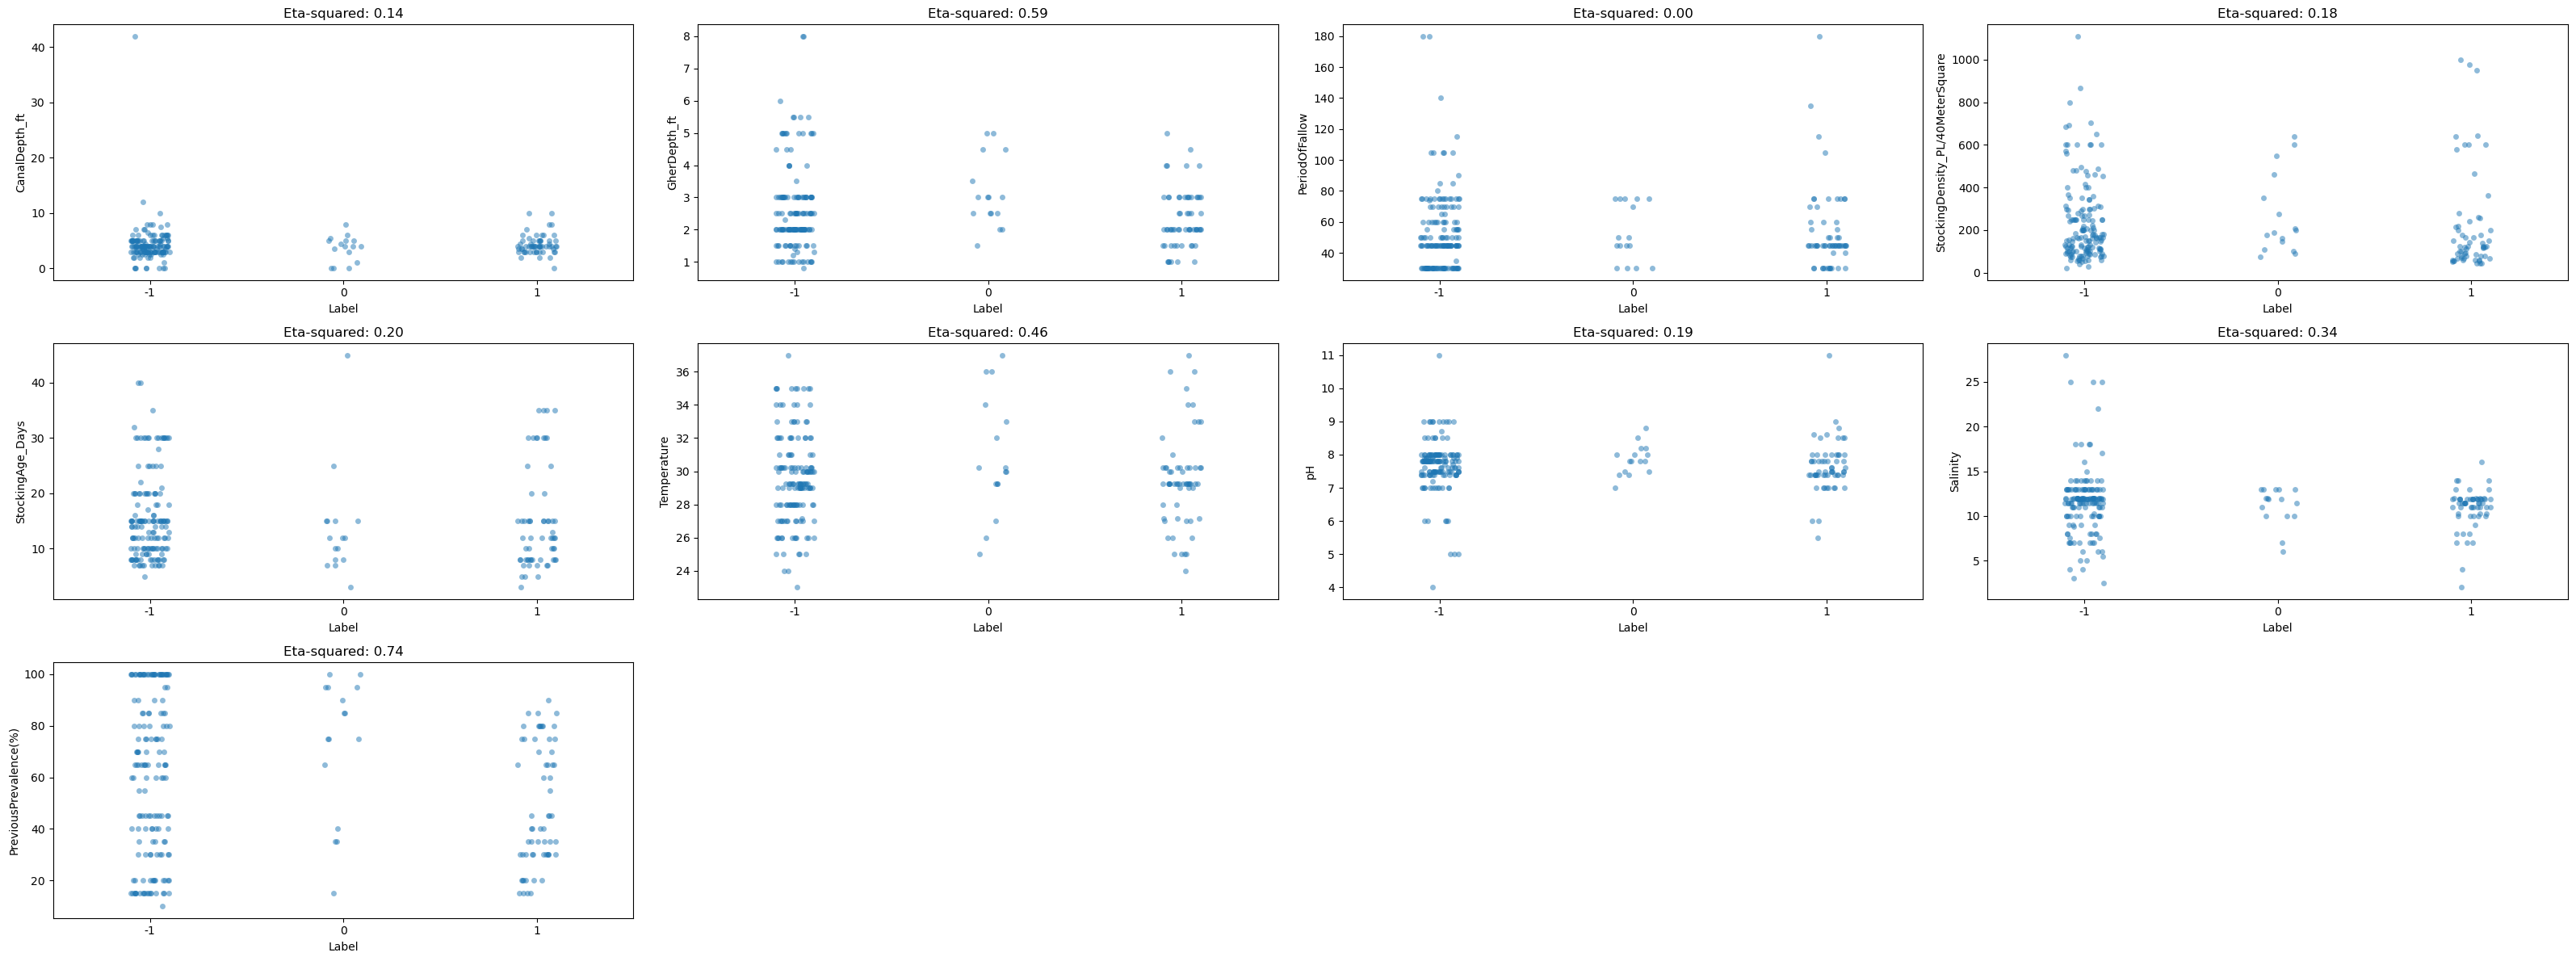

['PeriodOfFallow']


In [ ]:
def analyze_and_get_low_eta_squared_columns(df, label, continuous_columns, threshold):
    low_eta_squared_columns = []

    num_plots = len(continuous_columns)
    num_cols = 4
    num_rows = math.ceil(num_plots / num_cols)

    fig_width = 8 * num_cols
    fig_height = 4 * num_rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

    plot_num = 0
    for i in range(num_rows):
        for j in range(num_cols):
            if plot_num < num_plots:
                ax = axes[i, j]
                col = continuous_columns[plot_num]

                sns.stripplot(x=label, y=col, data=df, ax=ax, jitter=True, alpha=0.5)
                ax.set_xlabel("Label")
                ax.set_ylabel(col)

                f_statistic, _ = f_oneway(df[col][df[label] == -1], df[col][df[label] == 0], df[col][df[label] == 1])
                eta_squared = f_statistic / (f_statistic + 2)

                ax.set_title(f'Eta-squared: {eta_squared:.2f}')

                if eta_squared < threshold:
                    low_eta_squared_columns.append(col)

                plot_num += 1

    for i in range(num_plots, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    plt.tight_layout()
    plt.show()

    return low_eta_squared_columns

low_eta_squared_cols = analyze_and_get_low_eta_squared_columns(df, 'change', continuous_columns, 0.01)

print(low_eta_squared_cols)

In [ ]:
df = df.drop(columns=low_eta_squared_cols, axis=1)

Dropped period of fallow for very poor corelation (<0.01)

"Categorical Feature" selection

> For nominal and binomial variables (categorical) we will use Cramer's V corelation

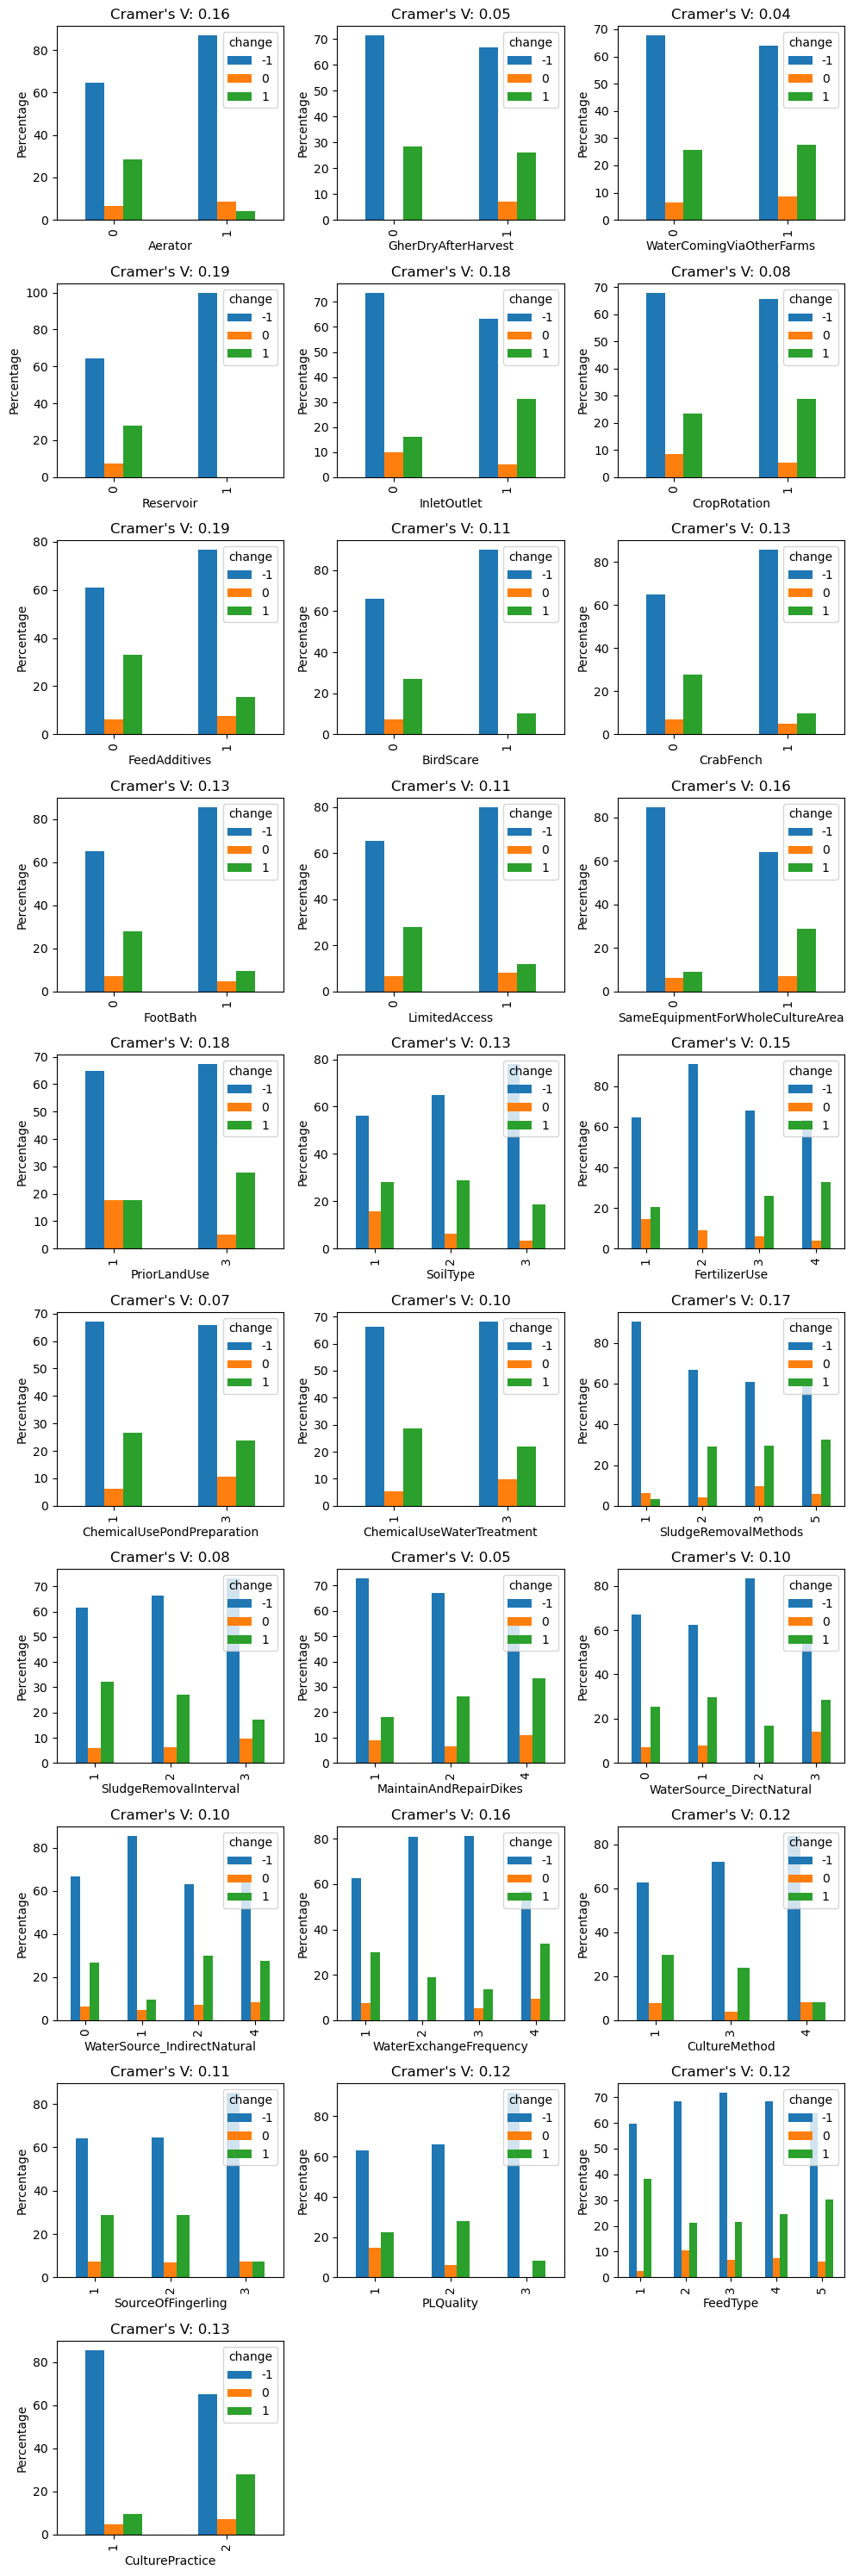

['GherDryAfterHarvest', 'WaterComingViaOtherFarms', 'CropRotation', 'ChemicalUsePondPreparation', 'SludgeRemovalInterval', 'MaintainAndRepairDikes', 'WaterSource_IndirectNatural']


In [ ]:
def cramers_v(crosstab):
    chi2 = chi2_contingency(crosstab)[0]
    n = crosstab.values.sum()
    phi = math.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))
    return phi

def analyze_and_get_low_correlation_columns(df, label_column, columns, threshold):
    low_correlation_columns = []

    num_plots = len(columns)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        crosstab = pd.crosstab(df[column], df[label_column])
        percentages = crosstab.div(crosstab.sum(1), axis=0) * 100
        percentages.plot(kind='bar', ax=axes[i])

        axes[i].set_xlabel(column)
        axes[i].set_ylabel("Percentage")
        v_corr = cramers_v(crosstab)
        axes[i].set_title(f"Cramer's V: {v_corr:.2f}")

        if v_corr < threshold:
            low_correlation_columns.append(column)

    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    return low_correlation_columns

categorical_columns = binary_columns + nominal_columns
low_correlation_columns = analyze_and_get_low_correlation_columns(df, 'change', categorical_columns, 0.1)
print(low_correlation_columns)

In [ ]:
df = df.drop(columns=low_correlation_columns, axis=1)

In [ ]:
df.head()

,PriorLandUse,SoilType,CanalDepth_ft,GherDepth_ft,FertilizerUse,ChemicalUseWaterTreatment,Aerator,SludgeRemovalMethods,WaterSource_DirectNatural,Reservoir,...,CrabFench,FootBath,LimitedAccess,SameEquipmentForWholeCultureArea,CulturePractice,Temperature,pH,Salinity,PreviousPrevalence(%),change
0,3,1,7.0,5.0,1,1,0,3,0,0,...,0,0,0,1,2,28.000000,8.000000,9.000000,70,-1
1,3,2,7.0,3.0,3,1,0,2,3,0,...,0,0,0,1,2,30.237705,7.809917,11.397581,20,-1
2,3,2,6.0,4.0,4,3,0,2,3,0,...,0,0,0,1,2,30.237705,7.809917,11.397581,75,-1
3,3,2,6.0,4.0,4,1,0,2,3,0,...,0,0,0,1,2,30.237705,7.809917,2.000000,15,1
4,3,2,6.0,2.5,4,3,0,1,1,0,...,0,0,0,1,2,24.000000,7.500000,11.000000,15,1


Dropped the following categorical columns due to very poor corelations (<0.1):
> 'GherDryAfterHarvest', 'WaterComingViaOtherFarms', 'CropRotation', 'ChemicalUsePondPreparation', 'SludgeRemovalInterval', 'MaintainAndRepairDikes', 'WaterSource_IndirectNatural'

Preprocessing Data:

* All nominal values will be one hot encoded

* All continous values will be scaled using a min max scaler

In [ ]:
def one_hot_encode_and_rename(df, columns_to_encode):

    df_encoded = df.copy()

    for column in columns_to_encode:
        if column in df.columns:
            one_hot = pd.get_dummies(df_encoded[column], prefix=column)
            df_encoded = pd.concat([df_encoded, one_hot], axis=1)
            df_encoded = df_encoded.drop(column, axis=1)

    return df_encoded

In [ ]:
def normalize_continuous_variables(df, columns_to_normalize):

    df_normalized = df.copy()

    scaler = MinMaxScaler()

    for column in columns_to_normalize:
        if column in df.columns and "current" not in column:
            df_normalized[column] = scaler.fit_transform(df_normalized[[column]])

    return df_normalized

In [ ]:
df = one_hot_encode_and_rename(df, nominal_columns)
df = normalize_continuous_variables(df, continuous_columns)
df.head()

,CanalDepth_ft,GherDepth_ft,Aerator,Reservoir,InletOutlet,StockingDensity_PL/40MeterSquare,StockingAge_Days,FeedAdditives,BirdScare,CrabFench,...,PLQuality_1,PLQuality_2,PLQuality_3,FeedType_1,FeedType_2,FeedType_3,FeedType_4,FeedType_5,CulturePractice_1,CulturePractice_2
0,0.166667,0.583333,0,0,0,0.083410,0.285714,1,0,0,...,False,True,False,False,False,True,False,False,False,True
1,0.166667,0.305556,0,0,1,0.133822,0.095238,1,0,0,...,False,True,False,False,False,True,False,False,False,True
2,0.142857,0.444444,0,0,1,0.073327,0.119048,0,0,0,...,False,True,False,False,True,False,False,False,False,True
3,0.142857,0.444444,0,0,1,0.063245,0.047619,0,0,0,...,False,True,False,False,True,False,False,False,False,True
4,0.142857,0.236111,0,0,0,0.021998,0.642857,1,0,0,...,False,True,False,False,False,False,True,False,False,True


For RF we will select the best combination of features based on importance score For knn and nb we will use kbest feature selector as they don't have any inherent method to score importance of features

**Random Forest Classifier**

> First we will see importance score across all features to get an idea of threshold value ranges

> Then we will use a range of threshold values to select features and for each feature selection, over a number of estimators we will find the highest performing model.

> We will also find the best number of estimators for each set of selected features

> Then we will fine tune it repeatedly in the range our optimal hyperparameters fall on until we land on a single value

In [ ]:
rf_model = RandomForestClassifier(random_state=8)
rf_model.fit(X, y)

feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                             Feature  Importance
16             PreviousPrevalence(%)    0.104799
5   StockingDensity_PL/40MeterSquare    0.086338
6                   StockingAge_Days    0.071634
13                       Temperature    0.061807
15                          Salinity    0.060381
1                       GherDepth_ft    0.048679
0                      CanalDepth_ft    0.045958
14                                pH    0.043940
30            SludgeRemovalMethods_3    0.019289
39          WaterExchangeFrequency_4    0.019073
4                        InletOutlet    0.017419
7                      FeedAdditives    0.017347
27       ChemicalUseWaterTreatment_3    0.016213
33       WaterSource_DirectNatural_1    0.016160
40                   CultureMethod_1    0.015496
21                        SoilType_3    0.014692
20                        SoilType_2    0.014089
25                   FertilizerUse_4    0.013961
45              SourceOfFingerling_3    0.013953
26       ChemicalUse

In [ ]:
def find_optimal_parameters(X, y, thresholds, estimator_values):
    max_accuracy = 0
    optimal_threshold = None
    optimal_estimators = None
    optimal_df = X.copy()
    accuracy_scores = []

    rf_model = RandomForestClassifier(random_state=8)
    rf_model.fit(X, y)
    feature_importances = rf_model.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    for threshold in thresholds:
        selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]
        selected_df = X[selected_features['Feature']]

        accuracy_scores_row = []
        for n_estimators in estimator_values:
            rf_model = RandomForestClassifier(random_state=8, n_estimators=n_estimators)
            accuracy_scorer = make_scorer(accuracy_score)
            cv_accuracy_scores = cross_val_score(rf_model, selected_df, y, cv=10, scoring=accuracy_scorer)

            mean_accuracy = np.mean(cv_accuracy_scores)
            accuracy_scores_row.append(mean_accuracy)

            if mean_accuracy > max_accuracy:
                max_accuracy = mean_accuracy
                optimal_threshold = threshold
                optimal_estimators = n_estimators
                optimal_df = selected_df.copy()

        accuracy_scores.append(accuracy_scores_row)

    return max_accuracy, optimal_threshold, optimal_estimators, optimal_df, accuracy_scores

def plot_accuracy_heatmap(values1, values2, accuracy_scores, values1_name, values2_name):
    accuracy_scores = np.array(accuracy_scores, dtype=float)
    plt.figure(figsize=(10, 6))
    plt.imshow(accuracy_scores, cmap='viridis', origin='lower')
    plt.colorbar(label='Mean Accuracy')
    plt.xticks(np.arange(len(values1)), values1, rotation=45)
    plt.yticks(np.arange(len(values2)), values2)
    plt.xlabel(values1_name)
    plt.ylabel(values2_name)
    plt.title('Mean Accuracy Heatmap')
    plt.show()

Mean Accuracy for optimum params: 0.6989130434782609
Optimal Threshold: 0.01
Optimal Estimators: 50


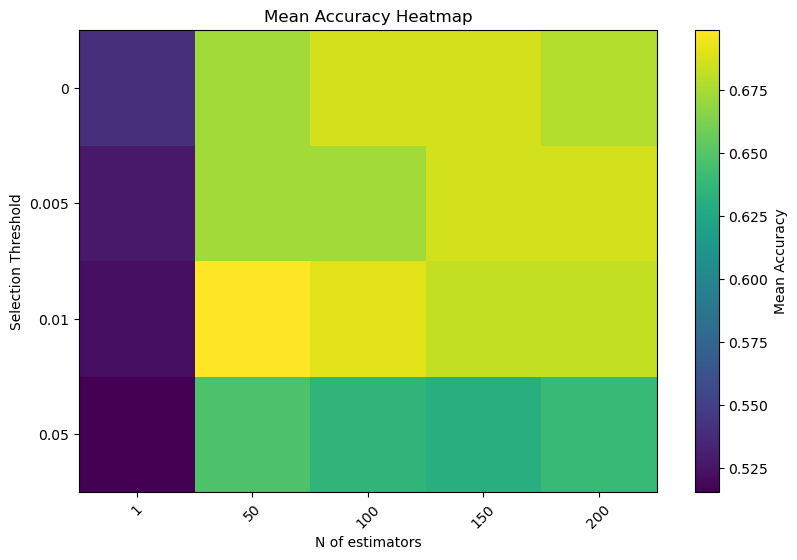

In [ ]:
thresholds = [0.05, 0.01, 0.005, 0]
estimator_values = [1, 50, 100, 150, 200]

max_accuracy, optimal_threshold, optimal_estimators, optimal_df_rf, accuracy_scores = find_optimal_parameters(X, y, thresholds, estimator_values)
print("Mean Accuracy for optimum params:", max_accuracy)
print("Optimal Threshold:", optimal_threshold)
print("Optimal Estimators:", optimal_estimators)

plot_accuracy_heatmap(estimator_values, thresholds, accuracy_scores, "N of estimators", "Selection Threshold")

Mean Accuracy for optimum params: 0.7164855072463767
Optimal Threshold: 0.006
Optimal Estimators: 80


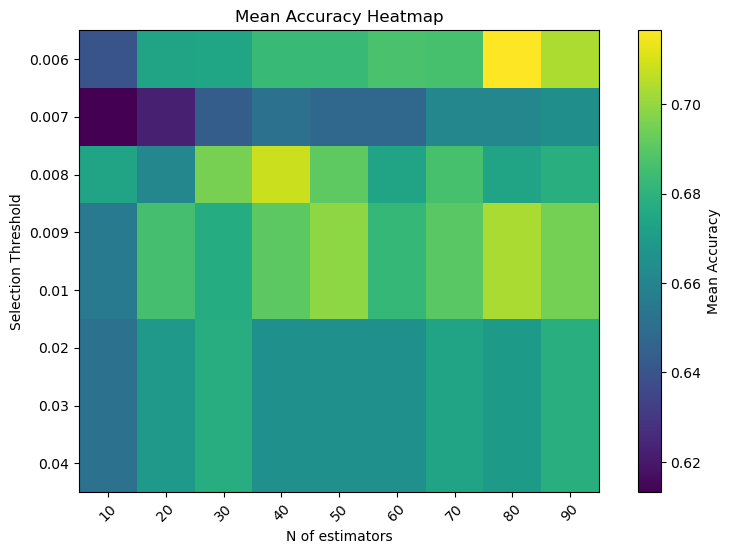

In [ ]:
thresholds = [0.04, 0.03, 0.02, 0.01, 0.009, 0.008, 0.007, 0.006]
estimator_values = [10, 20, 30, 40, 50, 60, 70, 80, 90]

max_accuracy, optimal_threshold, optimal_estimators, optimal_df_rf, accuracy_scores = find_optimal_parameters(X, y, thresholds, estimator_values)
print("Mean Accuracy for optimum params:", max_accuracy)
print("Optimal Threshold:", optimal_threshold)
print("Optimal Estimators:", optimal_estimators)

plot_accuracy_heatmap(estimator_values, thresholds, accuracy_scores, "N of estimators", "Selection Threshold")

Mean Accuracy for optimum params: 0.7164855072463767
Optimal Threshold: 0.006
Optimal Estimators: 80


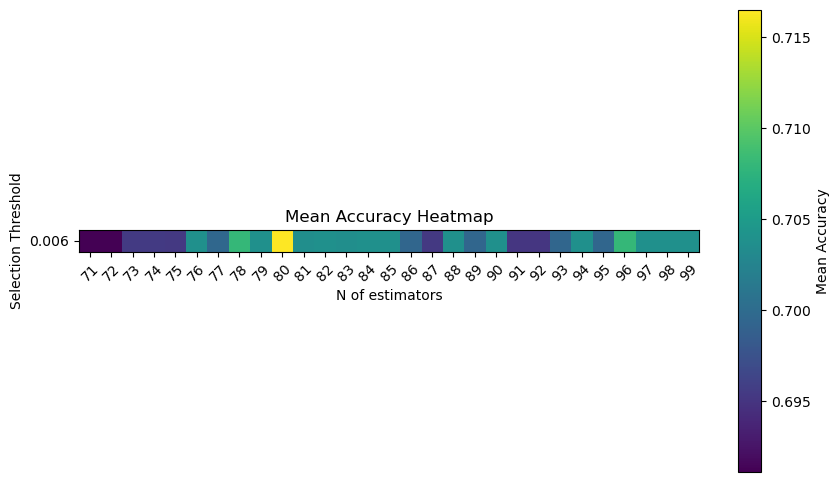

In [ ]:
thresholds = my_list = [0.006]
estimator_values = list(range(71, 100))

max_accuracy, optimal_threshold, optimal_estimators, optimal_df_rf, accuracy_scores = find_optimal_parameters(X, y, thresholds, estimator_values)
print("Mean Accuracy for optimum params:", max_accuracy)
print("Optimal Threshold:", optimal_threshold)
print("Optimal Estimators:", optimal_estimators)

plot_accuracy_heatmap(estimator_values, thresholds, accuracy_scores, "N of estimators", "Selection Threshold")

In [ ]:
optimal_df_rf.head()

,CanalDepth_ft,GherDepth_ft,InletOutlet,StockingDensity_PL/40MeterSquare,StockingAge_Days,FeedAdditives,SameEquipmentForWholeCultureArea,Temperature,pH,Salinity,...,SourceOfFingerling_1,SourceOfFingerling_2,SourceOfFingerling_3,PLQuality_1,PLQuality_2,FeedType_1,FeedType_2,FeedType_3,FeedType_4,FeedType_5
0,0.166667,0.583333,0,0.083410,0.285714,1,1,0.357143,0.571429,0.269231,...,True,False,False,False,True,False,False,True,False,False
1,0.166667,0.305556,1,0.133822,0.095238,1,1,0.516979,0.544274,0.361445,...,True,False,False,False,True,False,False,True,False,False
2,0.142857,0.444444,1,0.073327,0.119048,0,1,0.516979,0.544274,0.361445,...,True,False,False,False,True,False,True,False,False,False
3,0.142857,0.444444,1,0.063245,0.047619,0,1,0.516979,0.544274,0.000000,...,True,False,False,False,True,False,True,False,False,False
4,0.142857,0.236111,0,0.021998,0.642857,1,1,0.071429,0.500000,0.346154,...,False,True,False,False,True,False,False,False,True,False


**KNN classifier**

> First we will get the best features using select k best for a list of k

> We will also find the best number of neighbors for each set of selected features

> Then we will fine tune it repeatedly in the range our optimal hyperparameters fall on until we land on a single value

> We will do it twice, once for uniform voting and once for distance based voting

In [ ]:
def find_optimal_parameters(X, y, k_best_values, n_neighbors_values, voting="uniform"):
    max_accuracy = 0
    optimal_k_best = None
    optimal_n_neighbors = None
    optimal_df = X.copy()
    accuracy_scores = []

    for k_best in k_best_values:
        k_best_selector = SelectKBest(score_func=f_classif, k=k_best)
        selected_df = k_best_selector.fit_transform(X, y)

        accuracy_scores_row = []
        for n_neighbors in n_neighbors_values:
            knn_model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=voting)
            accuracy_scorer = make_scorer(accuracy_score)
            cv_accuracy_scores = cross_val_score(knn_model, selected_df, y, cv=10, scoring=accuracy_scorer)

            mean_accuracy = np.mean(cv_accuracy_scores)
            accuracy_scores_row.append(mean_accuracy)

            if mean_accuracy > max_accuracy:
                max_accuracy = mean_accuracy
                optimal_k_best = k_best
                optimal_n_neighbors = n_neighbors
                optimal_df = selected_df.copy()

        accuracy_scores.append(accuracy_scores_row)

    return max_accuracy, optimal_k_best, optimal_n_neighbors, optimal_df, accuracy_scores

For uniform voting
Mean Accuracy for optimum params: 0.6994565217391304
Optimal K value: 20
Optimal n value: 10


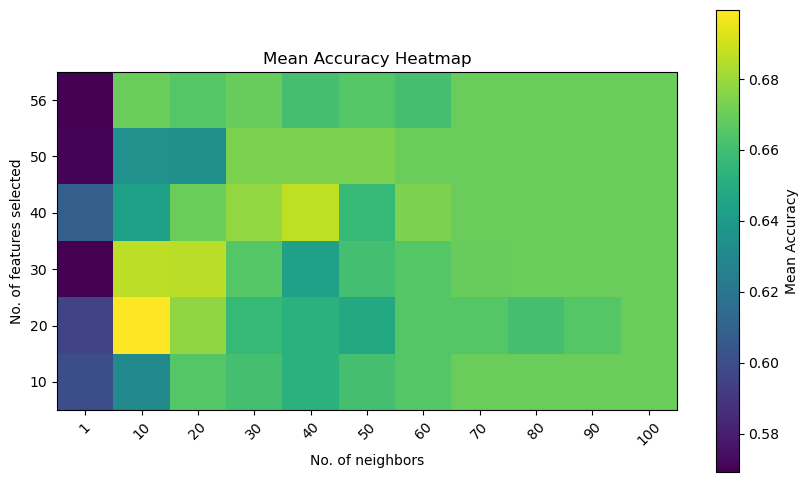

For distance based voting
Mean Accuracy for optimum params: 0.6943840579710145
Optimal K value: 20
Optimal n value: 10


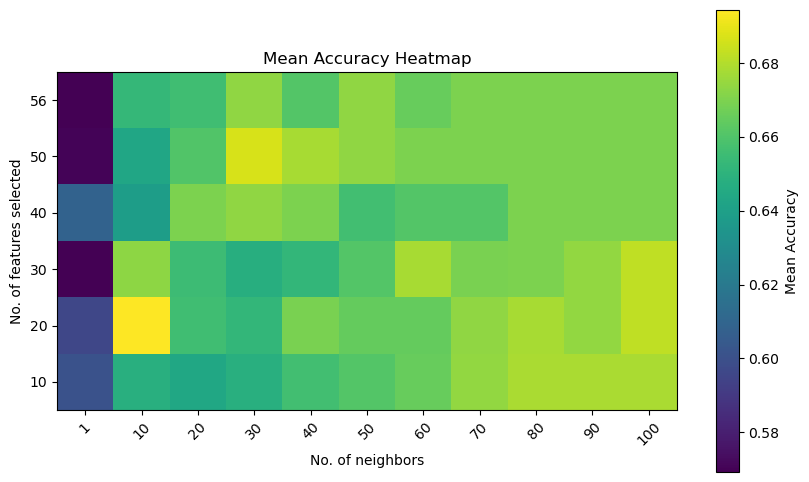

In [ ]:
k_best_values = [10, 20, 30, 40, 50, 56]
n_neighbors_values = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

max_accuracy, optimal_k_best, optimal_n_neighbors, optimal_df_knn_v, accuracy_scores = find_optimal_parameters(X, y, k_best_values, n_neighbors_values)
print("For uniform voting")
print("Mean Accuracy for optimum params:", max_accuracy)
print("Optimal K value:", optimal_k_best)
print("Optimal n value:", optimal_n_neighbors)
plot_accuracy_heatmap(n_neighbors_values, k_best_values, accuracy_scores, "No. of neighbors", "No. of features selected")

max_accuracy, optimal_k_best, optimal_n_neighbors, optimal_df_knn_d, accuracy_scores = find_optimal_parameters(X, y, k_best_values, n_neighbors_values, voting="distance")
print("For distance based voting")
print("Mean Accuracy for optimum params:", max_accuracy)
print("Optimal K value:", optimal_k_best)
print("Optimal n value:", optimal_n_neighbors)
plot_accuracy_heatmap(n_neighbors_values, k_best_values, accuracy_scores, "No. of neighbors", "No. of features selected")

For uniform voting
Mean Accuracy for optimum params: 0.7208333333333333
Optimal K value: 18
Optimal n value: 14


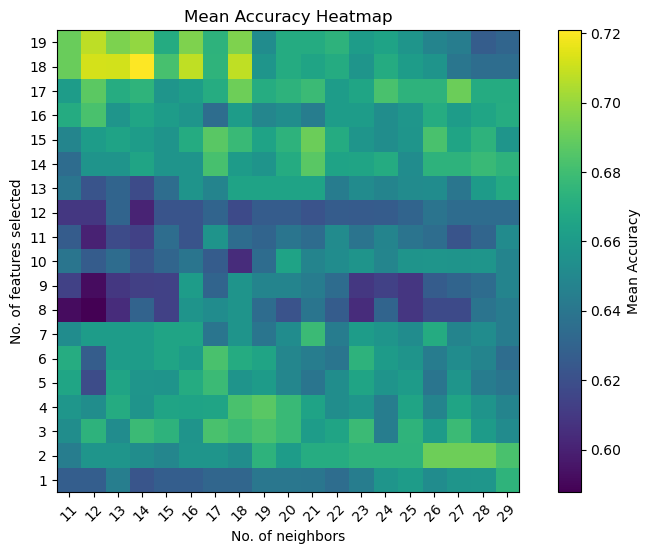

For distance based voting
Mean Accuracy for optimum params: 0.7077898550724638
Optimal K value: 18
Optimal n value: 13


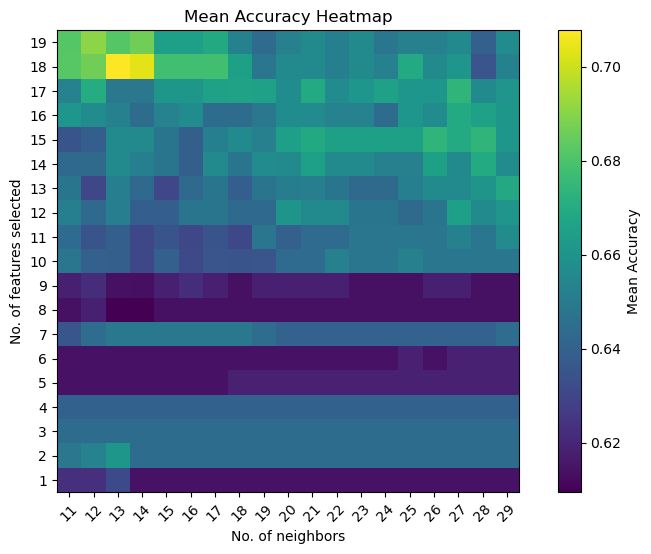

In [ ]:
k_best_values = list(range(1, 20, 1))
n_neighbors_values = list(range(11, 30, 1))

max_accuracy, optimal_k_best, optimal_n_neighbors, optimal_df_knn_v, accuracy_scores = find_optimal_parameters(X, y, k_best_values, n_neighbors_values)
print("For uniform voting")
print("Mean Accuracy for optimum params:", max_accuracy)
print("Optimal K value:", optimal_k_best)
print("Optimal n value:", optimal_n_neighbors)
plot_accuracy_heatmap(n_neighbors_values, k_best_values, accuracy_scores, "No. of neighbors", "No. of features selected")

max_accuracy, optimal_k_best, optimal_n_neighbors, optimal_df_knn_d, accuracy_scores = find_optimal_parameters(X, y, k_best_values, n_neighbors_values, voting="distance")
print("For distance based voting")
print("Mean Accuracy for optimum params:", max_accuracy)
print("Optimal K value:", optimal_k_best)
print("Optimal n value:", optimal_n_neighbors)
plot_accuracy_heatmap(n_neighbors_values, k_best_values, accuracy_scores, "No. of neighbors", "No. of features selected")

Multinomial Naive Bayes Classifier

> Then we will use a range of k best values to select features and for each feature selection, over a number of alpha values we will find the highest performing model.

> Then we will fine tune our hyperparameters around the optimum value

In [ ]:
def find_optimal_parameters(X, y, kbest_values, alpha_values):
    max_accuracy = 0
    optimal_kbest = None
    optimal_alpha = None
    optimal_df = X.copy()
    accuracy_scores = []

    for kbest in kbest_values:
        k_best = SelectKBest(score_func=f_classif, k=kbest)
        X_new = k_best.fit_transform(X, y)

        accuracy_scores_row = []
        for alpha in alpha_values:
            nb_model = MultinomialNB(alpha=alpha)
            accuracy_scorer = make_scorer(accuracy_score)
            cv_accuracy_scores = cross_val_score(nb_model, X_new, y, cv=10, scoring=accuracy_scorer)

            mean_accuracy = np.mean(cv_accuracy_scores)
            accuracy_scores_row.append(mean_accuracy)

            if mean_accuracy > max_accuracy:
                max_accuracy = mean_accuracy
                optimal_kbest = kbest
                optimal_alpha = alpha
                optimal_df = X_new.copy()

        accuracy_scores.append(accuracy_scores_row)

    return max_accuracy, optimal_kbest, optimal_alpha, optimal_df, accuracy_scores

Mean Accuracy for optimum params: 0.6610507246376812
Optimal K value: 20
Optimal alpha value: 0.2


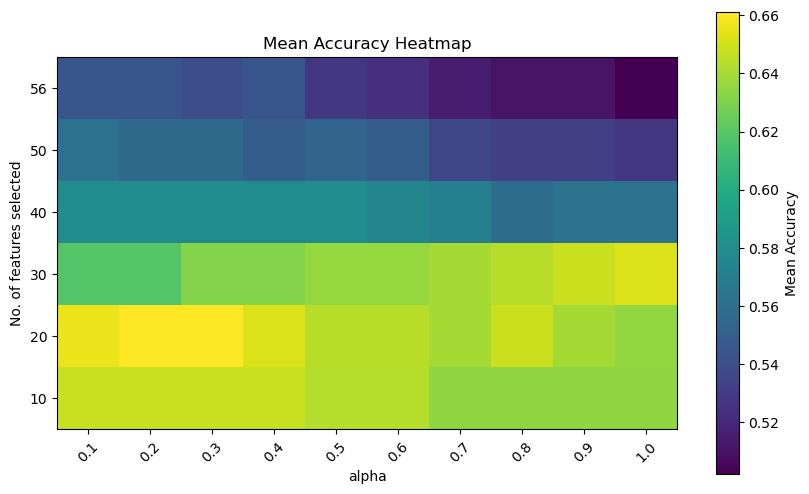

In [ ]:
kbest_values = [10, 20, 30, 40, 50, 56]
alpha_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
max_accuracy, optimal_kbest, optimal_alpha, optimal_df_nb, accuracy_scores = find_optimal_parameters(X, y, kbest_values, alpha_values)
print("Mean Accuracy for optimum params:", max_accuracy)
print("Optimal K value:", optimal_kbest)
print("Optimal alpha value:", optimal_alpha)
plot_accuracy_heatmap(alpha_values, kbest_values, accuracy_scores, "alpha", "No. of features selected")

Mean Accuracy for optimum params: 0.6610507246376812
Optimal K value: 19
Optimal alpha value: 0.11


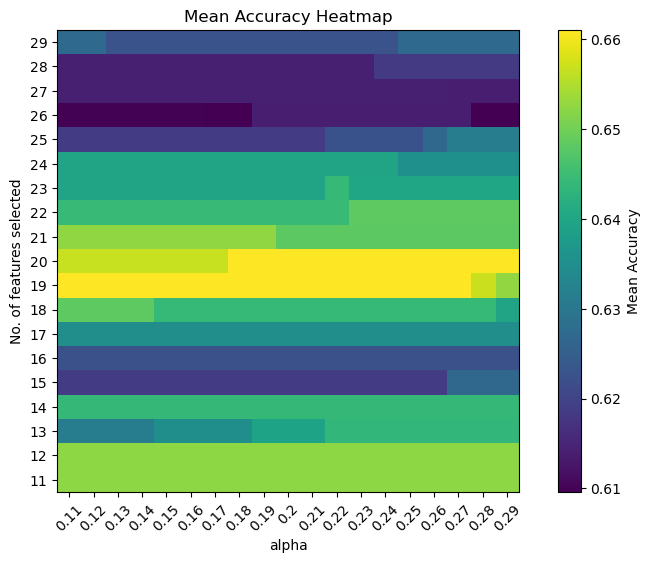

In [ ]:
kbest_values = list(range(11, 30, 1))
alpha_values = [x / 100 for x in range(11, 30)]

max_accuracy, optimal_kbest, optimal_alpha, optimal_df_nb, accuracy_scores = find_optimal_parameters(X, y, kbest_values, alpha_values)
print("Mean Accuracy for optimum params:", max_accuracy)
print("Optimal K value:", optimal_kbest)
print("Optimal alpha value:", optimal_alpha)
plot_accuracy_heatmap(alpha_values, kbest_values, accuracy_scores, "alpha", "No. of features selected")

**Now we will ensemble the 3 classifier with their optimum hyperparameters and selected features, and get the mean accuracy across a 10 fold cross validation test**

In [ ]:
n_splits = 10

stratified_kf = StratifiedKFold(n_splits=n_splits)

rf_classifier = RandomForestClassifier(n_estimators=80, random_state=8)
knn_classifier = KNeighborsClassifier(n_neighbors=14)
nb_classifier = MultinomialNB(alpha=0.11)

k_best = SelectKBest(score_func=f_classif, k=18)
selected_features = k_best.fit_transform(X, y)
selected_indices = k_best.get_support(indices=True)
selected_column_names = X.columns[selected_indices]

k_best = SelectKBest(score_func=f_classif, k=19)
selected_features = k_best.fit_transform(X, y)
selected_indices = k_best.get_support(indices=True)
selected_column_names2 = X.columns[selected_indices]

rf_col = optimal_df_rf.columns
knn_col = selected_column_names
nb_col = selected_column_names2

accuracy_scores = []

for train_index, test_index in stratified_kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    X_train_rf, X_test_rf = X_train[rf_col], X_test[rf_col]
    X_train_knn, X_test_knn = X_train[knn_col], X_test[knn_col]
    X_train_nb, X_test_nb = X_train[nb_col], X_test[nb_col]

    rf_classifier.fit(X_train_rf, y_train)
    knn_classifier.fit(X_train_knn, y_train)
    nb_classifier.fit(X_train_nb, y_train)

    rf_predictions = rf_classifier.predict(X_test_rf)
    knn_predictions = knn_classifier.predict(X_test_knn)
    nb_predictions = nb_classifier.predict(X_test_nb)

    all_predictions = [rf_predictions, knn_predictions, nb_predictions]

    final_predictions = []

    for i in range(len(rf_predictions)):
        predictions = [rf_predictions[i], knn_predictions[i], nb_predictions[i]]

        if len(set(predictions)) == 3:
            final_predictions.append(knn_predictions[i])
        else:
            most_common = max(set(predictions), key=predictions.count)
            final_predictions.append(most_common)

    final_predictions = np.array(final_predictions)
    accuracy = accuracy_score(y_test, final_predictions)
    accuracy_scores.append(accuracy)

mean_accuracy = sum(accuracy_scores) / len(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)


Mean Accuracy: 0.7166666666666666


**Result**

> Random Forest -->
* Accuracy: 71.65%
* n_estimators = 80
* importance score > 0.06

> 🏅 KNN -->
* Accuracy: 72.1%
* n_neighbors = 14
* voting = uniform  
* select k best, where k = 18

> Multinomial naive bayes -->
* accuracy: 66.1%
* alpha = 0.11  
* select k best, where k = 19

> Ensemble of the above 3 with their optimum param and optimum feature sets -->
* accuracy: 71.67%
* voting: hard voting, and if tie select prediction of knn (as it was best in individual setting)

**Analyze effect of different farm features and practices using explainable AI**

> We will use KNN with optimum hyperparameters and selected feature sets

> Using a 75-25 split with stratification

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=8, shuffle=True,  stratify=y)
X_train, X_test = X_train[knn_col], X_test[knn_col]

  0%|          | 0/175 [00:00<?, ?it/s]

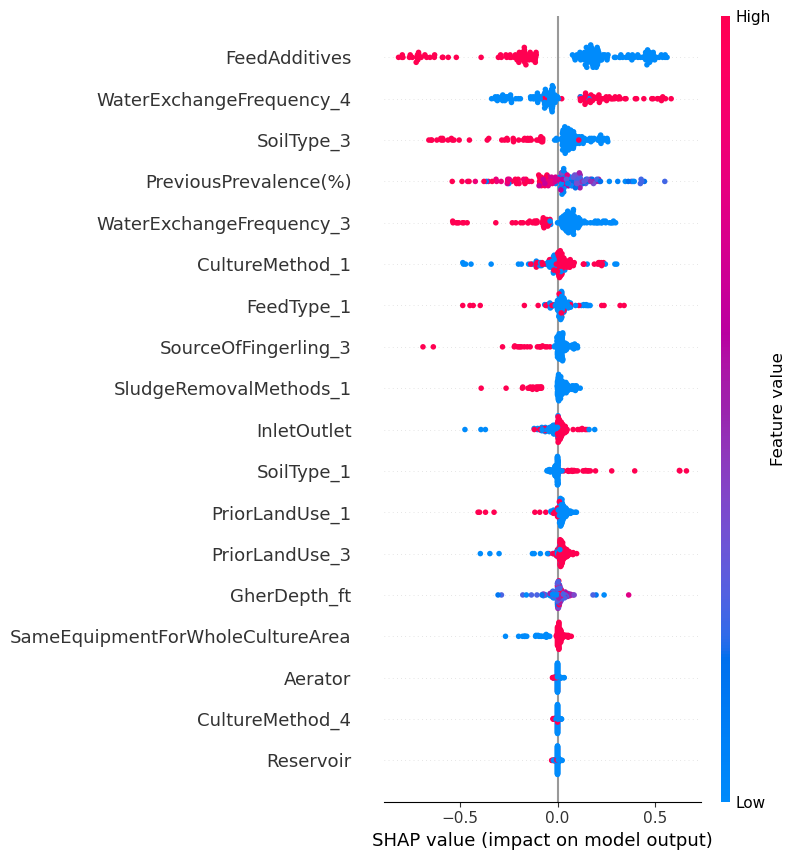

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=14)
knn_classifier.fit(X_train, y_train)

explainer = shap.KernelExplainer(knn_classifier.predict, X_train)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

  *More data and research is needed and results are not conclusive. However, based on available data and using analysis on our KNN classifier model we can see some pattern, which is by no means conclusive:*

> * Feed adative: use of feed addatives shows tends to have a significant impact in lowering prevalence of WSD

> * Water exchange: water exchange frequency of <7 - 28 days (water exchange 4) tends to have a significant impact in increasing prevalence of WSD. Water exchange frequency of every 29-42 days (water exchange 3) tends to have a significant impact in decreasing prevalence of WSD.

> * Soil type: Clay soil (soil type 1) tends to have a significant impact in increasing prevalence of WSD. Sandy soil (soil type 3) tends to have a significant impact in decreasing prevalence of WSD.

> * Culture method: Using a polyculture of shrimp with fish (culture method 1) tends to  have a modest impact in increasing prevalence of WSD. However, the trend is not consistent.

> * Source of fingerling: Using fingerling from regular hatchery (source of fingerling 3) tends to  have a modest impact in decreasing prevalence of WSD.

> * Sludge Removal Method: Flushing and depositing sludge off farm (sludge removal method 1) tends to  have a modest impact in decreasing prevalence of WSD.

> * Inlet/Outlet: Using separate passes for water inlet and outlet tends to  have a modest impact in decreasing prevalence of WSD. However, the trend is not consistent.

> * Prior Land Use: If a land was a wetland or other land not used for farming (prior land use 1), it tends to  have a modest impact in decreasing prevalence of WSD. If land was rich and was used for farming (prior land use 3), it tends to  have a modest impact in increasing prevalence of WSD.

> Usage of same equipment for whole farm tends to have a small impact in increasing prevalence of WSD.